# Network Building

In [1]:
import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
import torch
freq = np.arange(5.00,1024,1/4)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7), #alpha
                                                stats.uniform(0,3)], #omega alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m) #Ground truth wih sigma noise

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### UNet (not working yet)

In [2]:
import torch
import torch.nn as nn

class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetEncoderBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoderBlock, self).__init__()
        self.conv_transpose = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv_transpose(x)
        x = self.relu(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.ModuleList([
            UNetEncoderBlock(in_channels, 64),
            UNetEncoderBlock(64, 128),
            UNetEncoderBlock(128, 256),
            UNetEncoderBlock(256, 512),
            UNetEncoderBlock(512, 1024)
        ])

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.ModuleList([
            UNetDecoderBlock(1024, 512),
            UNetDecoderBlock(512, 256),
            UNetDecoderBlock(256, 128),
            UNetDecoderBlock(128, 64),
            UNetDecoderBlock(64, out_channels)
        ])

    def forward(self, x):
        # Encoder
        encoder_outputs = []
        for layer in self.encoder:
            x = layer(x)
            encoder_outputs.append(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for i, layer in enumerate(self.decoder):
            x = layer(x)
            # Adjust the size of the encoder output for concatenation
            encoder_output = encoder_outputs[-(i + 2)]  # Adjusted index
            if encoder_output.size(2) != x.size(2):
                encoder_output = nn.functional.interpolate(encoder_output, size=x.size(2), mode='linear', align_corners=False)
            x = torch.cat([x, encoder_output], dim=1)

        return x


In [3]:
from torchsummary import summary
in_channels = 1
out_channels = 1
model = UNet(in_channels, out_channels)

# Print the model summary
summary(model, input_size=(1,64))

RuntimeError: Given transposed=1, weight of size [512, 256, 3], expected input[2, 1024, 128] to have 512 channels, but got 1024 channels instead

In [34]:
fake_input = torch.randn(1, 1, 64)  # Assuming 64 time steps
model = UNet(in_channels=1, out_channels=1)
# Print the output shape for verification
print("Fake Input Shape:", fake_input.shape)
output = model(fake_input)
print("Output Shape:", output.shape)


Fake Input Shape: torch.Size([1, 1, 64])


RuntimeError: Given transposed=1, weight of size [512, 256, 3], expected input[1, 1024, 128] to have 512 channels, but got 1024 channels instead

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2463.12it/s]


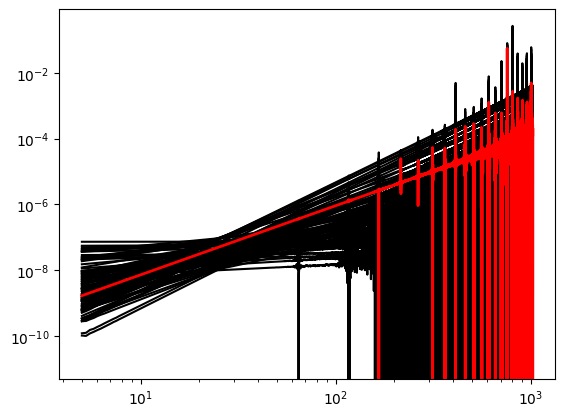

In [10]:
fref = 25
CE_PSD = np.genfromtxt("cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100)
for i in range(len(samples)):
    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

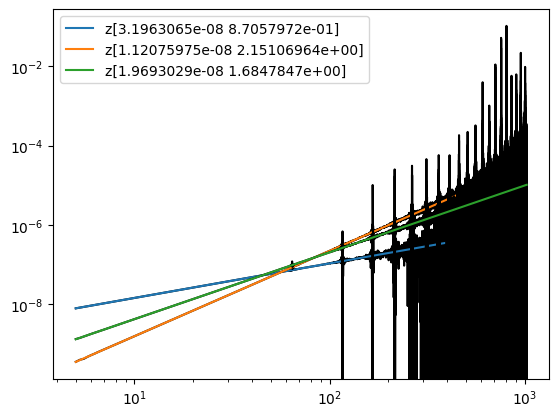

In [11]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

In [20]:
def round(obs, bounds=None):
    sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
    samples = sim.sample(20000) #20000 training samples
    dm = swyft.SwyftDataModule(samples, batch_size=64) #traing w samples
    trainer = swyft.SwyftTrainer(accelerator="cpu", precision = 64)
    #network = Network()
    network = UNet(in_channels=1, out_channels=1)
    #network = RNN()
    #network = SwishNet()
    #network = BatchNormNet()
    trainer.fit(network, dm) #fit network
    prior_samples = sim.sample(N = 10000, targets=['z']) #simulate ratio estimation
    predictions = trainer.infer(network, obs, prior_samples) #predictions
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', (2,), threshold=1e-2) #set new bounds for priors
    return predictions, new_bounds, samples

In [21]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(5):
    predictions, bounds, samples = round(obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

100%|██████████| 20000/20000 [00:06<00:00, 2894.19it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Lin

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 46.69it/s, loss=-0.634, v_num=47, val_loss=1.400]
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_47/checkpoints/epoch=0-step=250.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14623.92it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 29.18it/s]
New bounds: tensor([[1.0002e-08, 9.9986e-08],
        [1.6095e+00, 2.8046e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2906.76it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 46.26it/s, loss=-1.56, v_num=48, val_loss=14.60] 
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_48/checkpoints/epoch=1-step=500.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14376.41it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 27.38it/s]
New bounds: tensor([[1.0014e-08, 9.9972e-08],
        [1.6095e+00, 2.8045e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2942.71it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 313/313 [00:07<00:00, 42.45it/s, loss=-1.65, v_num=49, val_loss=7.730]
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_49/checkpoints/epoch=6-step=1750.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14564.24it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 27.91it/s]
New bounds: tensor([[4.5265e-08, 9.2286e-08],
        [1.9057e+00, 2.1179e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2949.47it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 10: 100%|██████████| 313/313 [00:07<00:00, 43.88it/s, loss=-1.52, v_num=50, val_loss=1.860]
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_50/checkpoints/epoch=5-step=1500.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 15761.14it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 28.57it/s]
New bounds: tensor([[5.3462e-08, 6.8909e-08],
        [1.9546e+00, 2.0698e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2898.97it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 42.42it/s, loss=-0.746, v_num=51, val_loss=0.811] 
Reloading best model: /Users/abbystokes/Documents/GitHub/DSMMA-Research/lightning_logs/version_51/checkpoints/epoch=0-step=250.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14883.06it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 27.20it/s]
New bounds: tensor([[5.3465e-08, 6.8909e-08],
        [1.9868e+00, 2.0698e+00]], dtype=torch.float64)


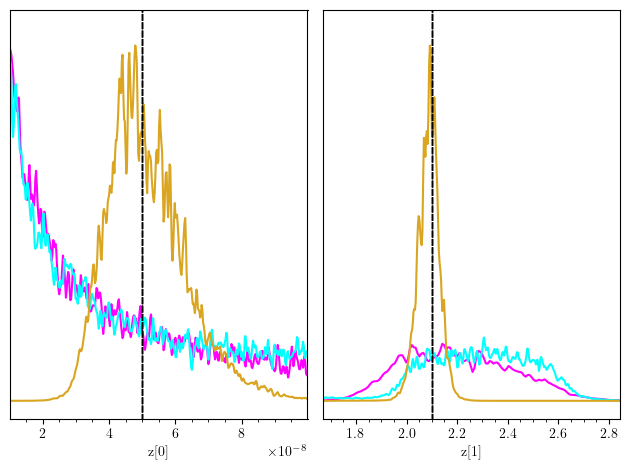

In [20]:
# Normal ReLu
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

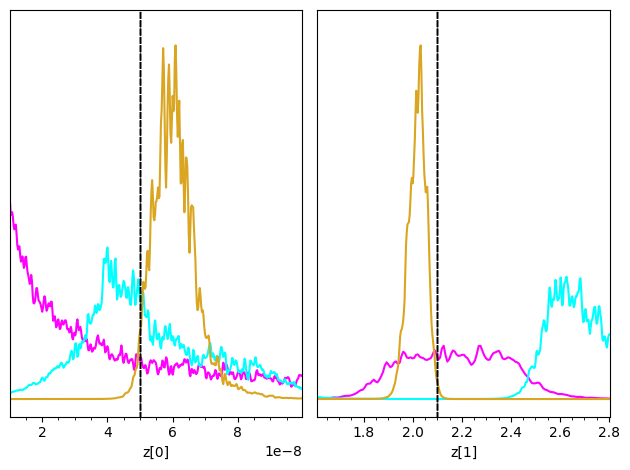

In [22]:
# Batch Normalization
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

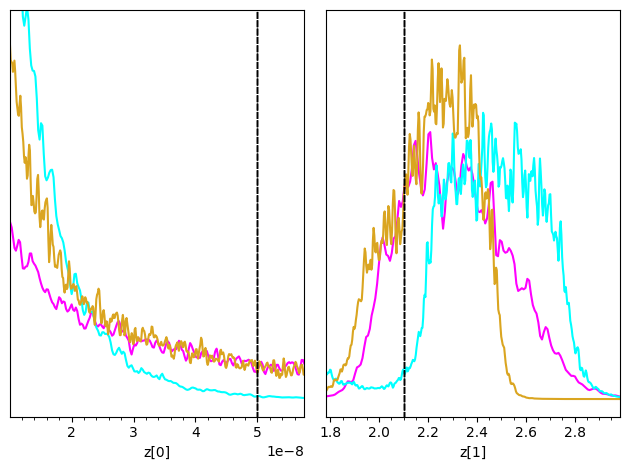

In [18]:
# Swish Activation
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])


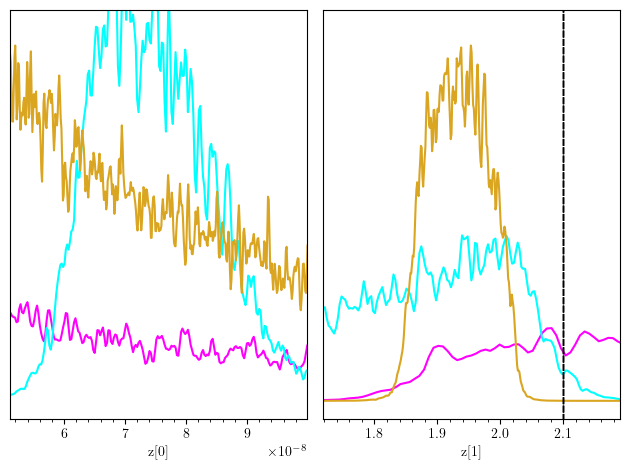

In [26]:
# Leaky Relu
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])
